# Decision Tree Classifier

This notebook is exploring SKLearn's DecisionTreeClassifier for feature information gain and as a prediction model.


### Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
import pydotplus
from IPython.display import Image, display,SVG

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

___
### Reading in Files

In [2]:
# read the file using pandas
train_file = 'split_train_clean.csv'
train = pd.read_csv(train_file)

# read the file using pandas
test_file = 'split_test_clean.csv'
test = pd.read_csv(test_file)

#reviewing columns
train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Type', 'Name', 'Age', 'Breed1_0',
       'Breed1_1', 'Breed1_2', 'Breed1_3', 'Breed1_4', 'Breed1_5', 'Breed1_6',
       'Breed1_7', 'Breed2_0', 'Breed2_1', 'Breed2_2', 'Breed2_3', 'Breed2_4',
       'Breed2_5', 'Breed2_6', 'MaturitySize', 'FurLength', 'Vaccinated_1',
       'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2',
       'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3', 'Health',
       'Quantity', 'Fee', 'StateID_0', 'StateID_1', 'StateID_2', 'StateID_3',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'vertex_xs', 'vertex_ys', 'bounding_confidences',
       'bounding_importance_fracs', 'dominant_blues', 'dominant_greens',
       'dominant_reds', 'dominant_pixel_fracs', 'dominant_scores',
       'label_descriptions', 'label_scores', 'doc_scores', 'doc_magnitudes',
       'languages', 'StateName', 'state_population', 'median_state_income',
       'Invalid_name', 'IsTopRescuer', 'RescuerC

In [3]:
train.AdoptionSpeed.value_counts()

4    3364
2    3231
3    2618
1    2463
0     318
Name: AdoptionSpeed, dtype: int64

___
### Define Functions

The following functions were pulled from Live Session notebooks and modified for a multi-outcome case.

In [4]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0:
            logprob = np.log2(probability)
        entropy_index -= probability * logprob

    return entropy_index

In [5]:
def get_parent_distribution(labels):
    ''' Computes parent distribution
    # param labels: an array of labels
    # return: an array representing the label distribution
    '''
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)

    # Initialize counters for all labels to zero.
    label_probs = np.zeros(num_labels)

    # Iterate over labels in the training data and update counts.
    for label in labels:
        index = np.where(unique_labels == label)[0][0]
        label_probs[index] += 1.0

    # Normalize to get a distribution.
    label_probs /= label_probs.sum()

    return label_probs

In [6]:
def binary_information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))

    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else:
            subset0.append(label)

    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))

    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy

    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

In [7]:
def multi_information_gain(data, labels, feature):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))

    # Create a dictionary to store subsets for each category of the feature.
    subsets = {}
    for datum, label in zip(data, labels):
        category = datum[feature]
        if category not in subsets:
            subsets[category] = []
        subsets[category].append(label)

    # Compute the entropy of each subset and weight according to their sizes.
    subset_entropies = []
    subset_weights = []
    for subset in subsets.values():
        subset_entropy = entropy(get_parent_distribution(subset))
        subset_entropies.append(subset_entropy)
        subset_weights.append(len(subset) / len(labels))

    # Compute the final entropy by weighting each subset's entropy.
    final_entropy = sum(weight * entropy for weight, entropy in zip(subset_weights, subset_entropies))

    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy


In [8]:
def plot_hist (data, title="", bins=4):
    '''
    Plot the distribution of label predictions.
    '''

    #set up figure and axes
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(data, bins=bins, range=(0, bins), edgecolor='black', rwidth=0.8)

    #setting labels
    ax.set_title(title)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')

    #annotating each count total
    for count, rect in zip(n, patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, int(count), ha='center', va='bottom')

    # Get the bin edges and compute the center positions
    bin_edges = np.histogram_bin_edges(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Setting x-axis ticks to integers 1 through 4
    x_ticks_labels = range(1, 5)
    plt.xticks(bin_centers, x_ticks_labels)

    plt.show()

In [9]:
# Define function to OHE selected columns
def OHE_vars(train, test, target):
    '''
    Takes in the train and test datasets, and the target feature to encode.
    Fits to the train and then transforms both and returns the entire dataset
    with the target feature transformed.
    '''
    
    # Check if column_name exists in the DataFrame
    if target not in train.columns:
        raise ValueError(f"Column '{target}' does not exist in the DataFrame.")
    
    #creating encoder
    temp_encoder = ce.OneHotEncoder(cols=[target])
    # fitting the encoder to train
    temp_encoder.fit(train)
    # transforming both datasets with encoder
    train = temp_encoder.transform(train)
    test = temp_encoder.transform(test)
    
    return train, test

In [10]:
# Binary Encoding function
def binary_encoding(train, test, target):
    '''
    Takes in the train and test datasets, and the target feature to encode. 
    Fits to the train and then transforms both and returns the entire dataset 
    with the target feature transformed.
    '''
    # Check if column_name exists in the DataFrame
    if target not in train.columns:
        raise ValueError(f"Column '{target}' does not exist in the DataFrame.")
    
    # creating the encoder
    temp_encoder = ce.BinaryEncoder(cols=[target])
    #fitting the encoder to train
    temp_encoder.fit(train)
    #transforming both datasets with encoder
    train = temp_encoder.transform(train)
    test = temp_encoder.transform(test)
    #returning both datasets
    return train, test

---
### Pre-Processing Data

We are performing the following pre-processing of the data:
 - Last minute feature transformations not included in File 3 for 'languages' and 'label_descriptions'
 - Removing irrelevant/problematic features
 - Reclassing the labels to combine the original 0 & 1 classes
 - Downsampling so that each class has the same number of samples. 
 - Shuffling entire dataset and resetting_index

In [11]:
#last minute feature transformations 
#OHE 'languages' feature
train, test = OHE_vars(train, test, 'languages')

#Binary Encoding for 'label_descriptions'
train, test = binary_encoding(train, test, 'label_descriptions')

In [12]:
#dropping features
drop_features = ["Name", "Description", "PetID", "StateName", 'label_scores', 'PhotoAmt', "Unnamed: 0.1", "Unnamed: 0"]
target = 'AdoptionSpeed'
train = train.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

# Group 0 & 1 and relabel target variable in train and test
relabel_dict = { 0:0, 1:0, 2:1, 3:2, 4:3 }
train['AdoptionSpeed'] = train['AdoptionSpeed'].map(relabel_dict)
test['AdoptionSpeed'] = test['AdoptionSpeed'].map(relabel_dict)

# Downsample so all 4 categories have equal reviews in train
group_size = 2607
temp_0 = train[train.AdoptionSpeed.eq(0)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_1 = train[train.AdoptionSpeed.eq(1)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_2 = train[train.AdoptionSpeed.eq(2)].sample(
    n=group_size,
    replace=False,
    random_state=42)

temp_3 = train[train.AdoptionSpeed.eq(3)].sample(
    n=group_size,
    replace=False,
    random_state=42)

train_bal = pd.concat(
    [temp_0, temp_1, temp_2, temp_3],
    axis=0)

# shuffle df_balanced
train_bal.sample(frac=1, random_state=42) # frac=1 retains all the data
train_bal.reset_index(drop=True, inplace=True) # reset index

print('After downsampling, our data contains', train_bal.shape[0], 'pets and', train_bal.shape[1], 'columns')

#creating a list of features
features = train.columns.tolist()
features.remove('AdoptionSpeed')

After downsampling, our data contains 10428 pets and 94 columns


In [13]:
# Value counts of re-labeled AdoptionSpeed
train_bal['AdoptionSpeed'].value_counts()

0    2607
1    2607
2    2607
3    2607
Name: AdoptionSpeed, dtype: int64

---
### Split into Training and Validation Sets

We are reserving 20% of our dataset for validation.  To ensure class balance we created above we are stratifying the split. 


In [14]:
#Split into X and Y arrays
X = np.array(train_bal.drop('AdoptionSpeed', axis=1))
y = np.array(train_bal['AdoptionSpeed'])

#Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  stratify = y,
                                                  random_state=42)

# Splitting test data into X and Y arrays
X_test = np.array(test.drop('AdoptionSpeed', axis=1))
y_test = np.array(test['AdoptionSpeed'])

# Check distribution
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 2085, 1: 2086, 2: 2085, 3: 2086}

---
## Exploring Informationg Gain

In [15]:
for feature in range(len(features)):
    IG = multi_information_gain(X_train, y_train, feature)
    print ('%d %.3f %s' %(feature, IG, features[feature]))

0 0.009 Type
1 0.069 Age
2 0.001 Breed1_0
3 0.001 Breed1_1
4 0.002 Breed1_2
5 0.007 Breed1_3
6 0.006 Breed1_4
7 0.008 Breed1_5
8 0.006 Breed1_6
9 0.008 Breed1_7
10 0.000 Breed2_0
11 0.001 Breed2_1
12 0.001 Breed2_2
13 0.000 Breed2_3
14 0.003 Breed2_4
15 0.001 Breed2_5
16 0.001 Breed2_6
17 0.008 MaturitySize
18 0.008 FurLength
19 0.013 Vaccinated_1
20 0.002 Vaccinated_2
21 0.010 Vaccinated_3
22 0.006 Dewormed_1
23 0.004 Dewormed_2
24 0.002 Dewormed_3
25 0.030 Sterilized_1
26 0.009 Sterilized_2
27 0.020 Sterilized_3
28 0.002 Health
29 0.008 Quantity
30 0.017 Fee
31 0.002 StateID_0
32 0.002 StateID_1
33 0.005 StateID_2
34 0.002 StateID_3
35 0.003 VideoAmt
36 0.118 vertex_xs
37 0.120 vertex_ys
38 0.007 bounding_confidences
39 0.030 bounding_importance_fracs
40 0.079 dominant_blues
41 0.076 dominant_greens
42 0.076 dominant_reds
43 1.718 dominant_pixel_fracs
44 1.962 dominant_scores
45 0.006 label_descriptions_0
46 0.000 label_descriptions_1
47 0.000 label_descriptions_2
48 0.004 label_desc

---
## Building Selected Mdoel

Below is the finalized, tuned model that we have selected.  Please see "Exploring Various Hyper-parameters Individually" section below where tuning of the various parameters were explored. 

Model DecisionTreeClassifier(max_depth=5, min_samples_leaf=200)
Train Accuracy: 0.39199232797890193
Validation Accuracy: 0.3835091083413231
F1 Score: 0.3603066976330781


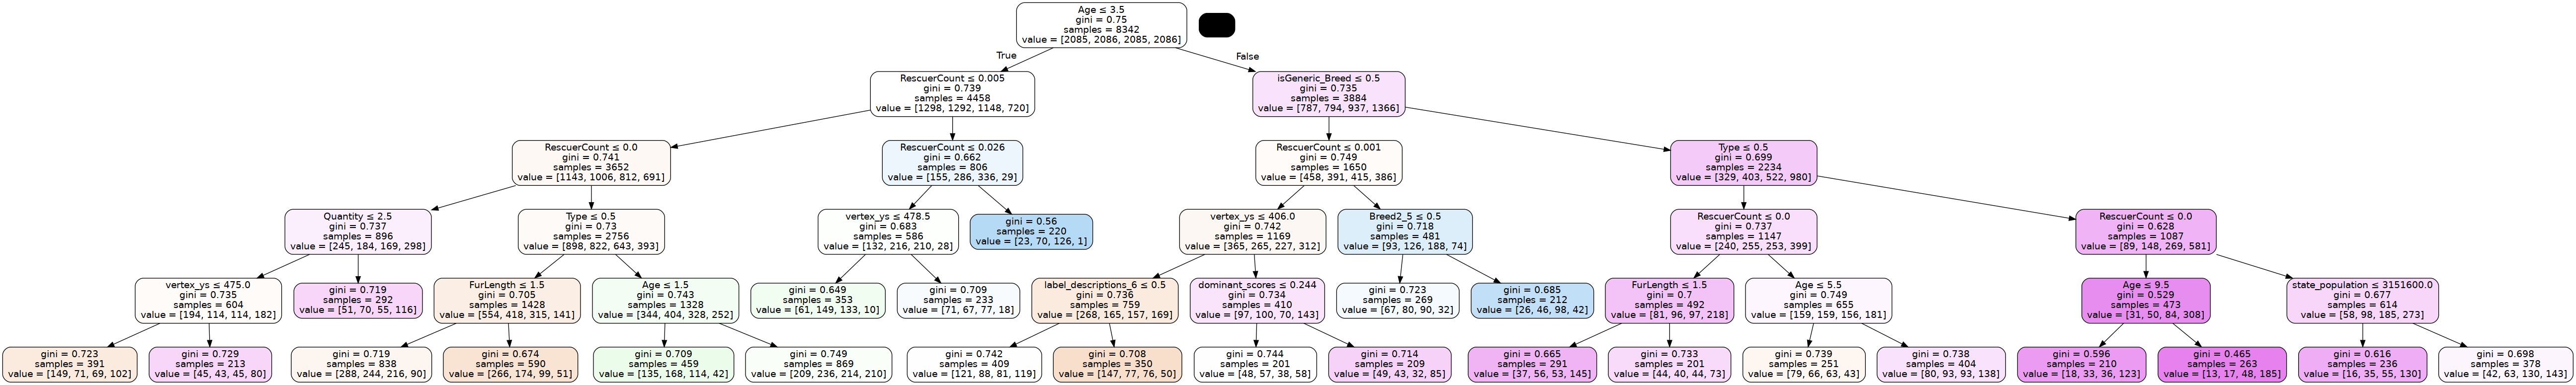

In [16]:
#dropping specific features from the model
#features to remove
remove_features = []
#updating list of features
features2 = [feature for feature in features if feature not in remove_features]
#updating train dataset
updated_train = train_bal.drop(remove_features, axis=1)
#Split into X and Y arrays
updated_X = np.array(updated_train.drop('AdoptionSpeed', axis=1))
updated_y = np.array(updated_train['AdoptionSpeed'])
#Split into train and validation
X_train2, X_val2, y_train2, y_val2 = train_test_split(updated_X, updated_y, test_size=0.2, stratify=updated_y, random_state=42)

# initialize classifier
dt = tree.DecisionTreeClassifier(
                                 max_depth = 5,
                                 min_samples_leaf = 200,
                                )

# fit the tree
dt_fitted_tuned = dt.fit(X_train2, y_train2)

# get training accuracies
y_pred = dt_fitted_tuned.predict(X_train2)
acc_train = accuracy_score(y_train2, y_pred)


# get validation accuracies
y_pred = dt_fitted_tuned.predict(X_val2)
acc_valid = accuracy_score(y_val2, y_pred)

print("Model", dt_fitted_tuned)
print("Train Accuracy:", acc_train)
print("Validation Accuracy:", acc_valid)

# Checking the F1 score
f1 = f1_score(y_val2, y_pred, average='weighted')
print("F1 Score:", f1)

# plot tree
dot_data = tree.export_graphviz(dt_fitted_tuned,
                            filled=True, rounded=True, special_characters=True,
                            feature_names = features2)

graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

---
## Model Evaluation

In [17]:
results = pd.DataFrame({'Features': features2, 'Feature Importances': dt.feature_importances_})
results = results.sort_values(by='Feature Importances', ascending=False)

results.head(15)

,Features,Feature Importances
63,RescuerCount,0.334191
1,Age,0.286694
91,isGeneric_Breed,0.133757
0,Type,0.114591
37,vertex_ys,0.045198
18,FurLength,0.023195
51,label_descriptions_6,0.016071
29,Quantity,0.014790
59,state_population,0.014525
15,Breed2_5,0.012053


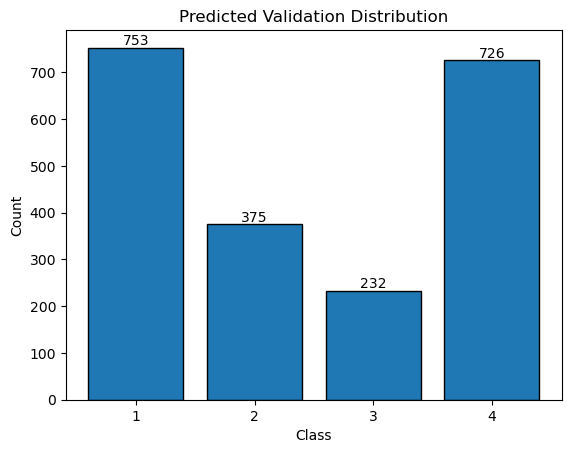

In [18]:
#reviewing the distribution of the predicted labels for Validation set
plot_hist(y_pred, "Predicted Validation Distribution")

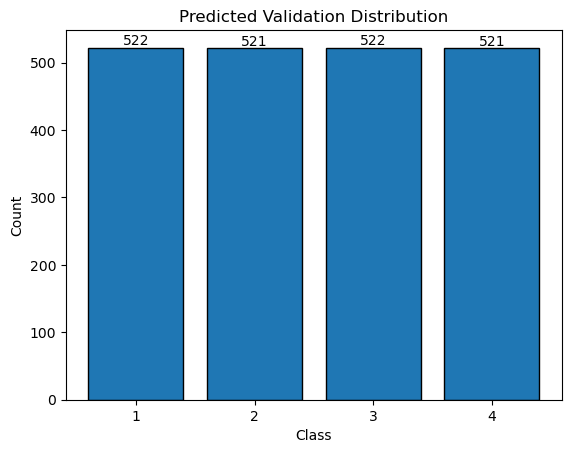

In [19]:
#reviewing the distribution of the predicted labels for Validation set
plot_hist(y_val, "Predicted Validation Distribution")

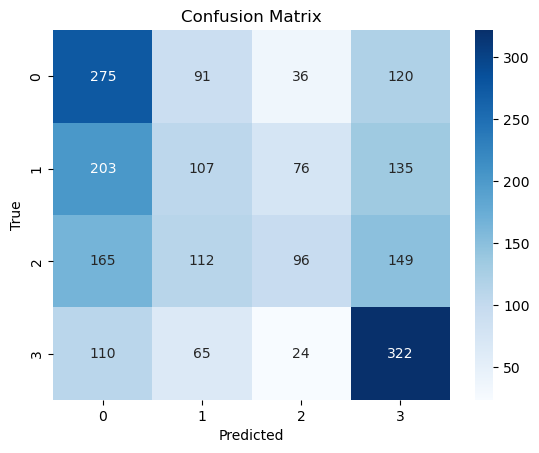

In [20]:
# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Get the class labels from y_val (assuming y_val contains all possible class labels)
class_labels = np.unique(y_val)

# Create a heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

---
## Model Evaluation with Test Dataset

The below section was created at the very end of this notebook to evaluate performance of our selected model on the test dataset.  We put it ahead of the Hyper-parameter tuning section to keep the chosen model results together. 

In [21]:
# get validation accuracies
y_test_pred = dt_fitted_tuned.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

#returning model accuracies
print("Model", dt_fitted_tuned)
print("Train Accuracy:", acc_train)
print("Validation Accuracy:", acc_valid)
print("Test Accuracy:", acc_test)

# Checking the F1 scores
f1_valid = f1_score(y_val2, y_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("Validation Weighted F1 Score:", f1_valid)
print("Test Weighted F1 Score:", f1_test)

Model DecisionTreeClassifier(max_depth=5, min_samples_leaf=200)
Train Accuracy: 0.39199232797890193
Validation Accuracy: 0.3835091083413231
Test Accuracy: 0.37679226408802935
Validation Weighted F1 Score: 0.3603066976330781
Test Weighted F1 Score: 0.37018974463792403


---
## Exploring Various Hyper-parameters Individually

Below are the various hyper-parameters that we explored in our effort to fine tune our model to our specific dataset. 

### A) Exploring 'max_depth'

Decision Tree with:  4
Test & Validation Accuracies: 0.3844401822105011 0.37583892617449666
Decision Tree with:  5
Test & Validation Accuracies: 0.40002397506593146 0.38207094918504314
Decision Tree with:  6
Test & Validation Accuracies: 0.4186046511627907 0.3868648130393097
Decision Tree with:  7
Test & Validation Accuracies: 0.4422200911052505 0.3763183125599233
Decision Tree with:  8
Test & Validation Accuracies: 0.48081994725485494 0.3772770853307766
Decision Tree with:  9
Test & Validation Accuracies: 0.5184608007672021 0.36433365292425696
Decision Tree with:  10
Test & Validation Accuracies: 0.5691680652121793 0.3638542665388303
Decision Tree with:  11
Test & Validation Accuracies: 0.6262287221289858 0.3566634707574305
Decision Tree with:  12
Test & Validation Accuracies: 0.6897626468472788 0.350431447746884
Decision Tree with:  13
Test & Validation Accuracies: 0.7483816830496284 0.3537871524448706
Decision Tree with:  14
Test & Validation Accuracies: 0.8044833373291777 0.3542665

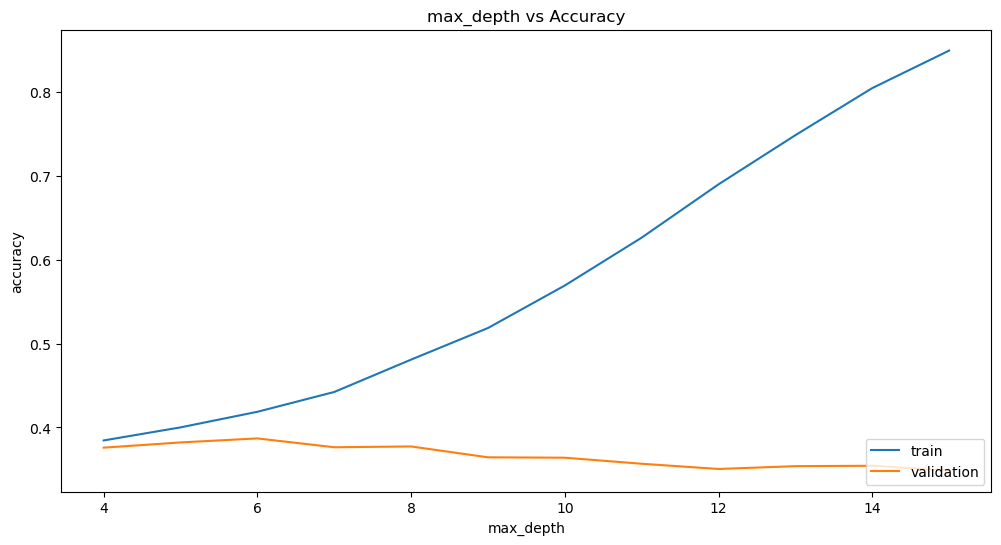

In [22]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'max_depth'
samples = range(4, 16, 1)

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(max_depth = sample)
    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)
   
    print("Decision Tree with: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    
# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()



### B) Exploring 'min_samples_leaf' Parameter

The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. The default value for this parameter is 1, which means that every leaf must have at least 1 sample that it classifies.

Decision Tree with:  50
Test & Validation Accuracies: 0.4007432270438744 0.387823585810163
Decision Tree with:  60
Test & Validation Accuracies: 0.4006233517142172 0.3854266538830297
Decision Tree with:  70
Test & Validation Accuracies: 0.3995444737473028 0.3835091083413231
Decision Tree with:  80
Test & Validation Accuracies: 0.3995444737473028 0.3835091083413231
Decision Tree with:  90
Test & Validation Accuracies: 0.3995444737473028 0.3835091083413231
Decision Tree with:  100
Test & Validation Accuracies: 0.3993047230879885 0.3844678811121764
Decision Tree with:  110
Test & Validation Accuracies: 0.3995444737473028 0.38302972195589646
Decision Tree with:  120
Test & Validation Accuracies: 0.39690721649484534 0.3854266538830297
Decision Tree with:  130
Test & Validation Accuracies: 0.3964277151762167 0.3854266538830297
Decision Tree with:  140
Test & Validation Accuracies: 0.395109086549988 0.38207094918504314
Decision Tree with:  150
Test & Validation Accuracies: 0.39474946056101656

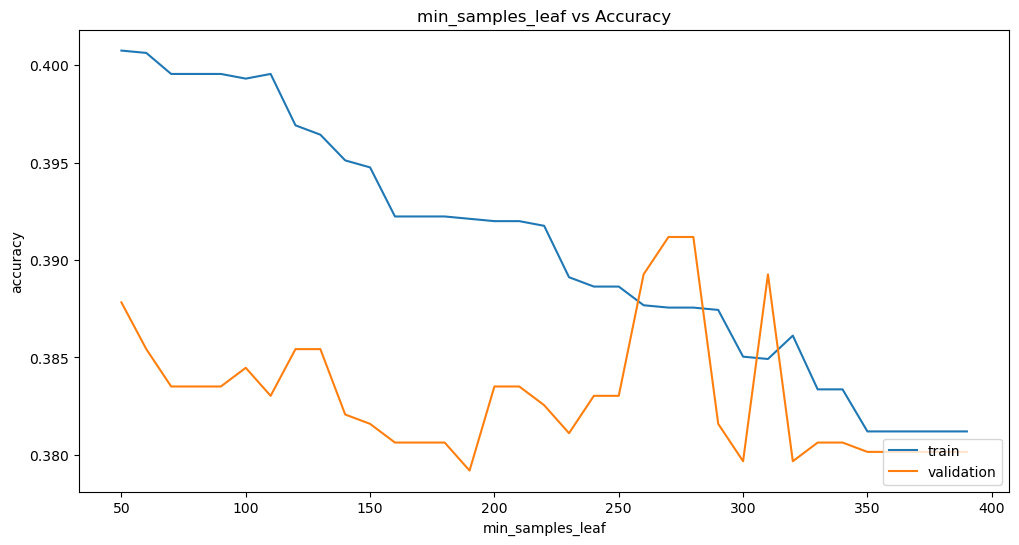

In [23]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'min_samples_leaf'
samples = range(50, 400, 10)

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(max_depth = 5,
                                     min_samples_leaf = sample
                                     )
    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)

    print("Decision Tree with: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    
# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

### C) Exploring 'min_samples_split'

The minimum number of samples required to split an internal node:

Decision Tree with:  200
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  250
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  300
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  350
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  400
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  450
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  500
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  550
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  600
Test & Validation Accuracies: 0.3907935746823304 0.38302972195589646
Decision Tree with:  650
Test & Validation Accuracies: 0.3865979381443299 0.3763183125599233
Decision Tree with:  700
Test & Validation Accuracies: 0.3822

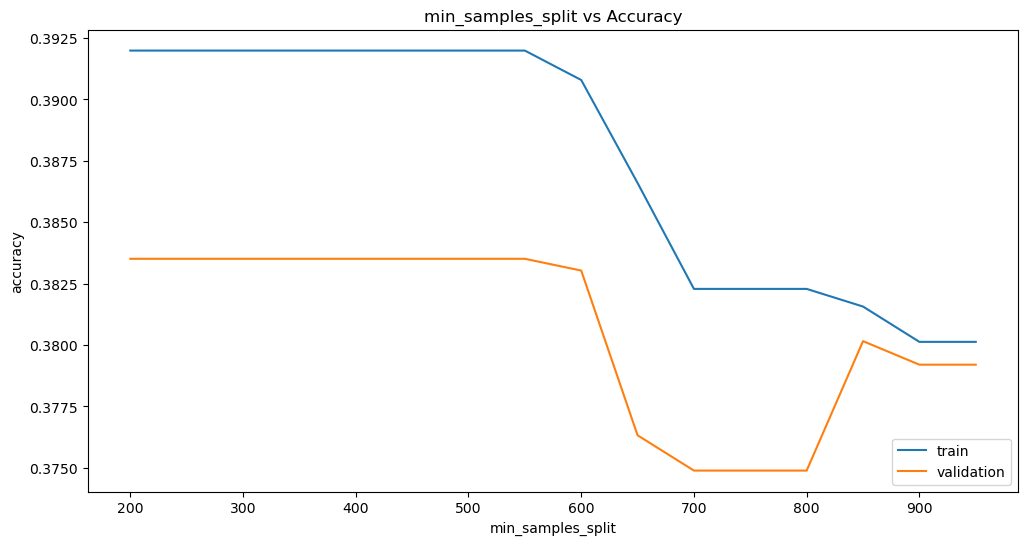

In [24]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'min_samples_split'
samples = range(200, 1000, 50)

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(min_samples_split = sample,
                                     max_depth = 5,
                                     min_samples_leaf = 200
                                     )
    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)

    # # plot the trees for each max_depth
    # dot_data = tree.export_graphviz(dt_fitted, max_depth=4, filled=True, rounded=True, special_characters=True,
    #                             feature_names = features)

    # graph = pydotplus.graph_from_dot_data(dot_data)
    print("Decision Tree with: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    # display(Image(graph.create_png()))

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

### D) Exploring 'splitter'

The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

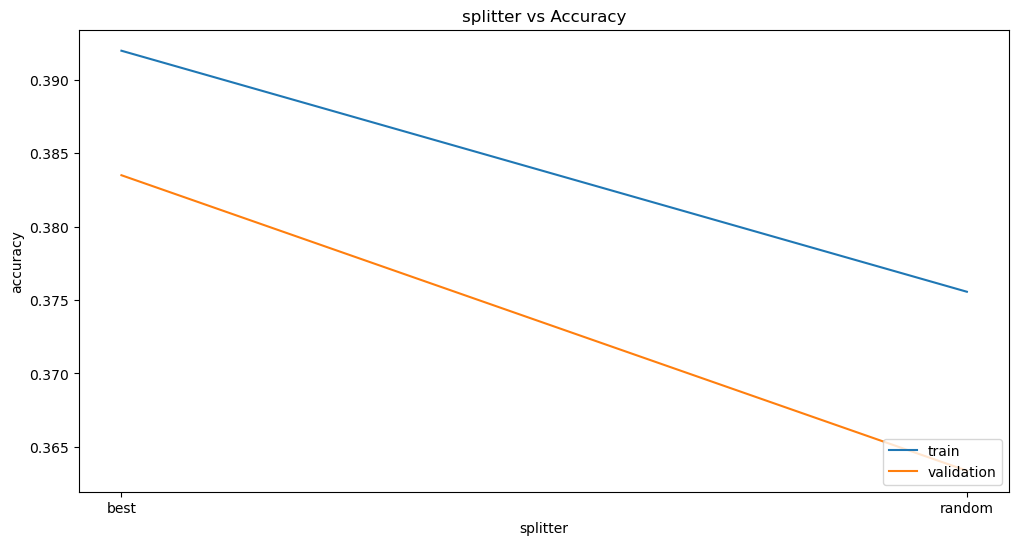

In [25]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'splitter'
samples = ['best', 'random']

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(splitter = sample,
                                     max_depth = 5,
                                     min_samples_leaf = 200
                                     )

    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)

    # # plot the trees for each max_depth
    # dot_data = tree.export_graphviz(dt_fitted, max_depth=4, filled=True, rounded=True, special_characters=True,
    #                             feature_names = features)

    # graph = pydotplus.graph_from_dot_data(dot_data)
    # print("Decision Tree with: ", sample)
    # print("Test & Validation Accuracies:", acc_train, acc_valid)
    # display(Image(graph.create_png()))

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

### E) Exploring 'min_weight_fraction_leaf'

The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

Decision Tree with:  0
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  5
Test & Validation Accuracies: 0.3795252936945577 0.37344199424736335
Decision Tree with:  10
Test & Validation Accuracies: 0.36190362023495565 0.3576222435282838
Decision Tree with:  15
Test & Validation Accuracies: 0.35027571325821144 0.3533077660594439
Decision Tree with:  20
Test & Validation Accuracies: 0.33649005034763846 0.33988494726749763
Decision Tree with:  25
Test & Validation Accuracies: 0.33613042435866697 0.3317353787152445
Decision Tree with:  30
Test & Validation Accuracies: 0.31934787820666505 0.31543624161073824
Decision Tree with:  35
Test & Validation Accuracies: 0.31934787820666505 0.31543624161073824
Decision Tree with:  40
Test & Validation Accuracies: 0.31934787820666505 0.31543624161073824
Decision Tree with:  45
Test & Validation Accuracies: 0.31934787820666505 0.31543624161073824


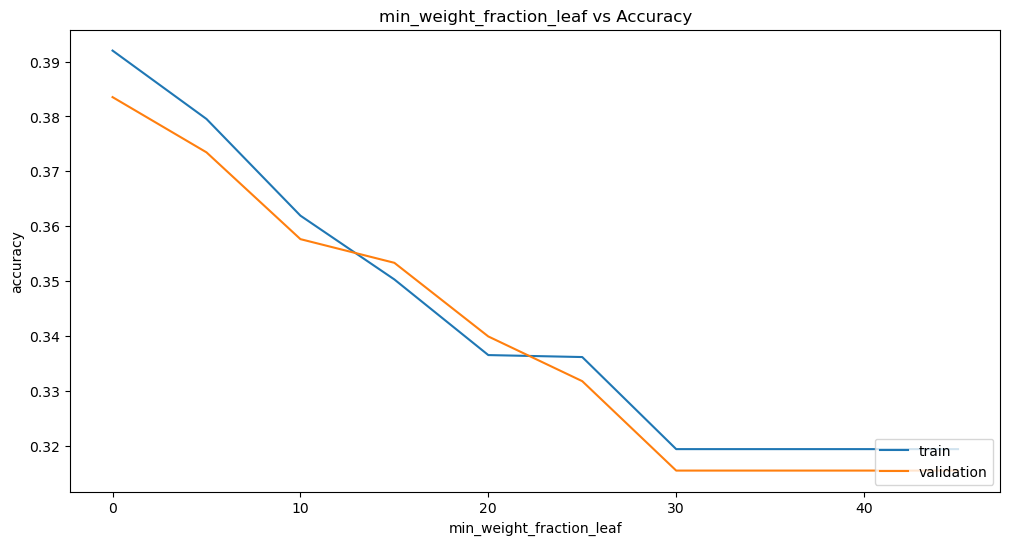

In [26]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'min_weight_fraction_leaf'
samples = range(0, 50, 5)

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(
                                     min_weight_fraction_leaf = sample/100,
                                     max_depth = 5,
                                     min_samples_leaf = 200
                                     )

    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)

    # # plot the trees for each max_depth
    # dot_data = tree.export_graphviz(dt_fitted, max_depth=4, filled=True, rounded=True, special_characters=True,
    #                             feature_names = features)

    # graph = pydotplus.graph_from_dot_data(dot_data)
    print("Decision Tree with: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    # display(Image(graph.create_png()))

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

### F) Exploring 'max_leaf_nodes'

Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

Decision Tree with:  20
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  21
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  22
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  23
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  24
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  25
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  26
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  27
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  28
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  29
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  30
Test & Validation Accuracies: 0.39199232797890

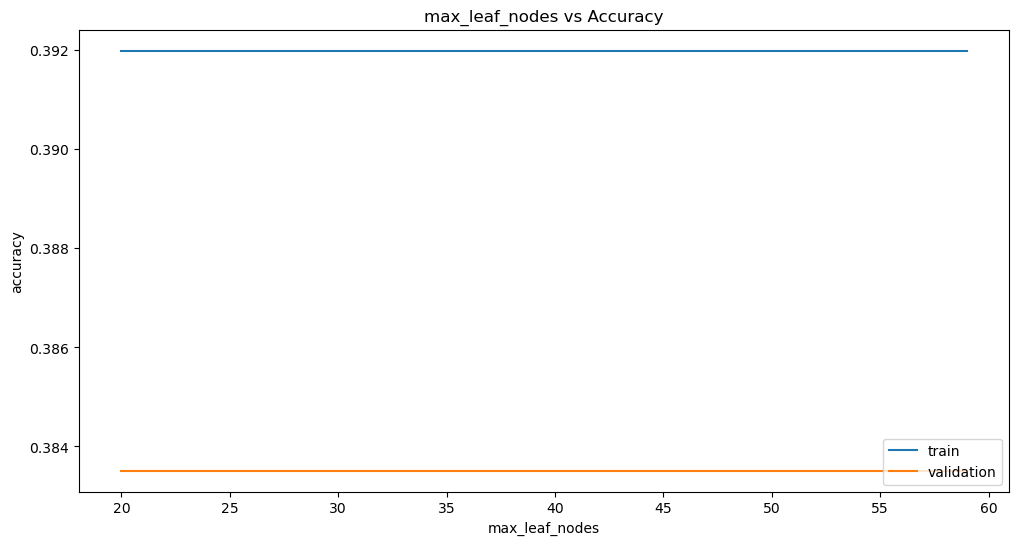

In [27]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'max_leaf_nodes'
samples = range(20, 60, 1)

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(max_leaf_nodes = sample,
                                    max_depth = 5,
                                    min_samples_leaf = 200
                                    )

    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)

    # # plot the trees for each max_depth
    # dot_data = tree.export_graphviz(dt_fitted, max_depth=4, filled=True, rounded=True, special_characters=True,
    #                             feature_names = features)

    # graph = pydotplus.graph_from_dot_data(dot_data)
    print("Decision Tree with: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    # display(Image(graph.create_png()))

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

### G) Exploring 'min_impurity_decrease'

A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

Decision Tree with:  0
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  1
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  2
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  3
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  4
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  5
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  6
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  7
Test & Validation Accuracies: 0.3907935746823304 0.38302972195589646
Decision Tree with:  8
Test & Validation Accuracies: 0.385159434188444 0.37535953978907
Decision Tree with:  9
Test & Validation Accuracies: 0.3808439223207864 0.37392138063279


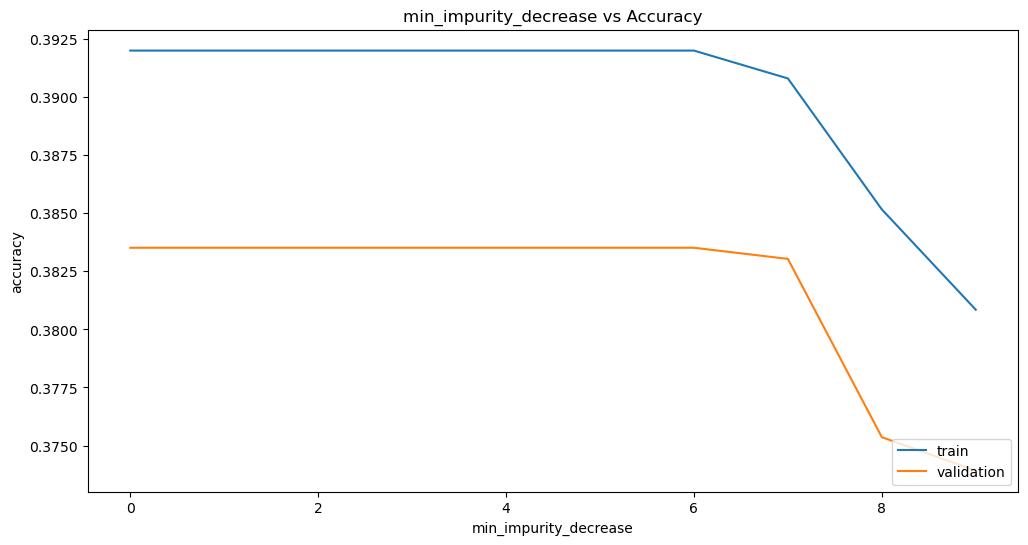

In [28]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'min_impurity_decrease'
samples = range(0, 10, 1)

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(min_impurity_decrease = sample/10000,
                                    max_depth = 5,
                                    min_samples_leaf = 200,
                                    )

    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)

    # # plot the trees for each max_depth
    # dot_data = tree.export_graphviz(dt_fitted, max_depth=4, filled=True, rounded=True, special_characters=True,
    #                             feature_names = features)

    # graph = pydotplus.graph_from_dot_data(dot_data)
    print("Decision Tree with: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    # display(Image(graph.create_png()))

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

### H) Exploring 'ccp_alpha'

Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.

Decision Tree with:  0
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  1
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  2
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  3
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  4
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  5
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  6
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree with:  7
Test & Validation Accuracies: 0.3907935746823304 0.38302972195589646
Decision Tree with:  8
Test & Validation Accuracies: 0.385159434188444 0.37535953978907
Decision Tree with:  9
Test & Validation Accuracies: 0.3808439223207864 0.37392138063279


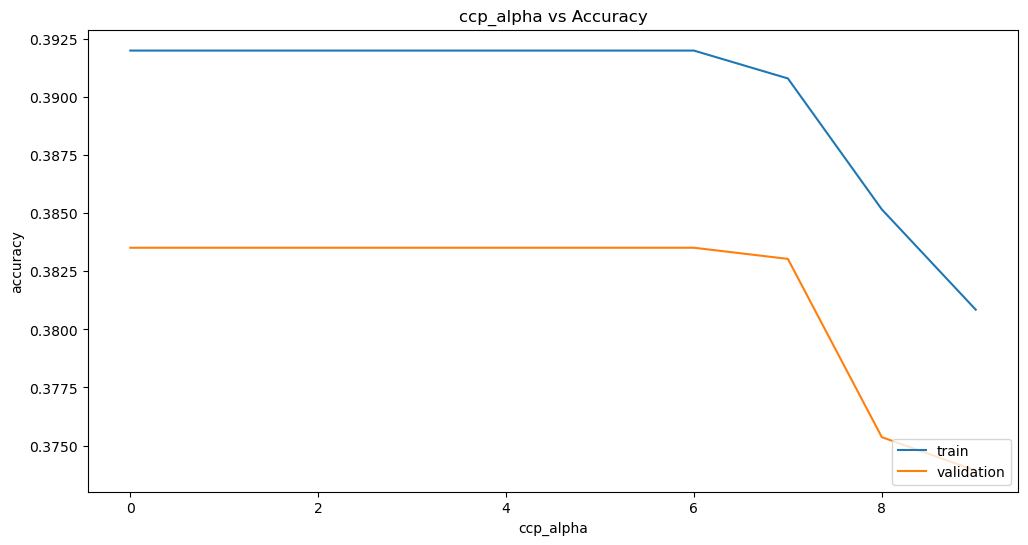

In [29]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'ccp_alpha'
samples = range(0, 10, 1)

# Try a range of different max_depths
for sample in samples:
    # initialize classifier
    dt = tree.DecisionTreeClassifier(ccp_alpha = sample/10000,
                                   max_depth = 5,
                                    min_samples_leaf = 200,
                                    )
    # fit the tree
    dt_fitted = dt.fit(X_train, y_train)

    # get training accuracies
    y_pred = dt_fitted.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    y_pred = dt_fitted.predict(X_val)
    acc_valid = accuracy_score(y_val, y_pred)
    valid_acc_track.append(acc_valid)

    # # plot the trees for each max_depth
    # dot_data = tree.export_graphviz(dt_fitted, max_depth=4, filled=True, rounded=True, special_characters=True,
    #                             feature_names = features)

    # graph = pydotplus.graph_from_dot_data(dot_data)
    print("Decision Tree with: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    # display(Image(graph.create_png()))

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

---
## Exploration of Dropping Specific Features

Looking to see if any of the high-IG features may just be by chance and whether their removal improves the model.

**NOTE: We have iterated through this notebook as we explored various features and how a combination of ommissions of features and revised hyper-tuning affects results. Through this process we have removed two features (which are now included in the initial drop of features at the beginning of this notebook). The two features were 'label_scores' and 'PhotoAmt'.  In both instances we found that the validation accuracy drastically improved with the removal of these features.  From a practical standpoint 'label_scores' was an abstract feature, and 'PhotoAmt' is also redundant with a 'has_Photo' features also in the dataset.**

In [30]:
results

,Features,Feature Importances
63,RescuerCount,0.334191
1,Age,0.286694
91,isGeneric_Breed,0.133757
0,Type,0.114591
37,vertex_ys,0.045198
...,...,...
30,Fee,0.000000
28,Health,0.000000
27,Sterilized_3,0.000000
26,Sterilized_2,0.000000


Decision Tree without:  RescuerCount
Test & Validation Accuracies: 0.3863581874850156 0.37775647171620325
Decision Tree without:  Age
Test & Validation Accuracies: 0.3850395588587869 0.36145733461169705
Decision Tree without:  isGeneric_Breed
Test & Validation Accuracies: 0.3846799328698154 0.37679769894535
Decision Tree without:  Type
Test & Validation Accuracies: 0.39319108127547353 0.3835091083413231
Decision Tree without:  vertex_ys
Test & Validation Accuracies: 0.39343083193478784 0.37488015340364333
Decision Tree without:  FurLength
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree without:  label_descriptions_6
Test & Validation Accuracies: 0.39355070726444497 0.3796740172579099
Decision Tree without:  Quantity
Test & Validation Accuracies: 0.39223207863821624 0.3796740172579099
Decision Tree without:  state_population
Test & Validation Accuracies: 0.39199232797890193 0.3835091083413231
Decision Tree without:  Breed2_5
Test & Validation Accuracie

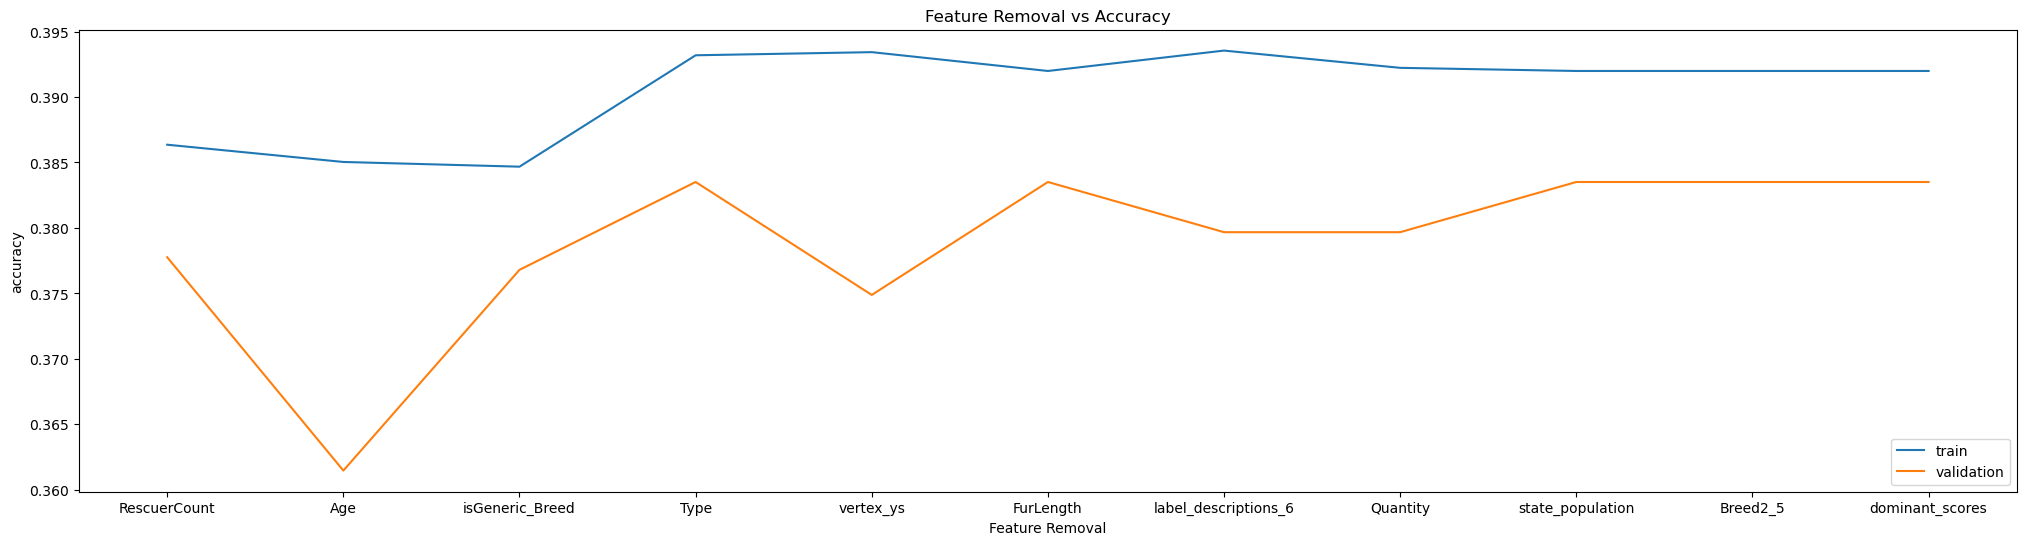

In [31]:
# Initialize lists to track accuracies
train_acc_track = []
valid_acc_track = []
testing = 'Feature Removal'
#collecting all relevant features from initial model build
samples = results.Features[results['Feature Importances'] != 0].to_list()

# Try a range of different
for sample in samples:
    temp_train = updated_train.drop(sample, axis=1)
    #Split into X and Y arrays
    temp_X = np.array(temp_train.drop('AdoptionSpeed', axis=1))
    temp_y = np.array(temp_train['AdoptionSpeed'])
    #Split into train and validation
    temp_X_train, temp_X_val, temp_y_train, temp_y_val = train_test_split(temp_X, temp_y, test_size=0.2, stratify=temp_y, random_state=42)

    # initialize classifier
    dt = tree.DecisionTreeClassifier(
                                    max_depth = 5,
                                    min_samples_leaf = 200,
                                    )
    
    # fit the tree
    dt_fitted = dt.fit(temp_X_train, temp_y_train)

    # get training accuracies
    temp_y_pred = dt_fitted.predict(temp_X_train)
    acc_train = accuracy_score(temp_y_train, temp_y_pred)
    train_acc_track.append(acc_train)

    # get validation accuracies
    temp_y_pred = dt_fitted.predict(temp_X_val)
    acc_valid = accuracy_score(temp_y_val, temp_y_pred)
    valid_acc_track.append(acc_valid)

    # # plot the trees for each max_depth
    # dot_data = tree.export_graphviz(dt_fitted, max_depth=4, filled=True, rounded=True, special_characters=True,
    #                             feature_names = features)

    # graph = pydotplus.graph_from_dot_data(dot_data)
    print("Decision Tree without: ", sample)
    print("Test & Validation Accuracies:", acc_train, acc_valid)
    # display(Image(graph.create_png()))

# Create plot of accuracies
fig, ax = plt.subplots(figsize = (25,6))
ax.set_xlabel(testing)
ax.set_ylabel('accuracy')

# Title and legend
plt.title(f'{testing} vs Accuracy')
ax.plot(samples, train_acc_track)
ax.plot(samples, valid_acc_track)
plt.legend(['train', 'validation'], loc ="lower right")
plt.show()

---
## Optimized Hyperparameter Tuning

We experimented with a cross-validation tool "GridSearchCV" as another check on hyper-parameter validation. 

In [32]:
# Choose hyperparameters to be optimized from above exercise
hyperparams = {
    'max_depth': range(4,10,1),
    'min_samples_leaf': range(80, 300, 20),
    'criterion': ['gini']
}

In [33]:
# Define decision tree classifier using gini
dtree = DecisionTreeClassifier()

In [34]:
# Use a grid search to find the optimal hyperparams
tree_grid_search = GridSearchCV(dtree, hyperparams, scoring= 'accuracy', cv = 5, verbose=0)
tree_grid_search.fit(X_train2, y_train2)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(4, 10),
                         'min_samples_leaf': range(80, 300, 20)},
             scoring='accuracy')

In [35]:
# Use best splitter to get "best" model
best_model = tree_grid_search.best_estimator_
accuracy = tree_grid_search.best_score_
val_accuracy = best_model.score(X_val2, y_val2)

# Check accuracy on train and validation
print("Best model after grid search: ", best_model)
print("Best Accuracy (training set):", accuracy)
print("Validation Accuracy:", val_accuracy)

Best model after grid search:  DecisionTreeClassifier(max_depth=5, min_samples_leaf=80)
Best Accuracy (training set): 0.378809450941344
Validation Accuracy: 0.3835091083413231


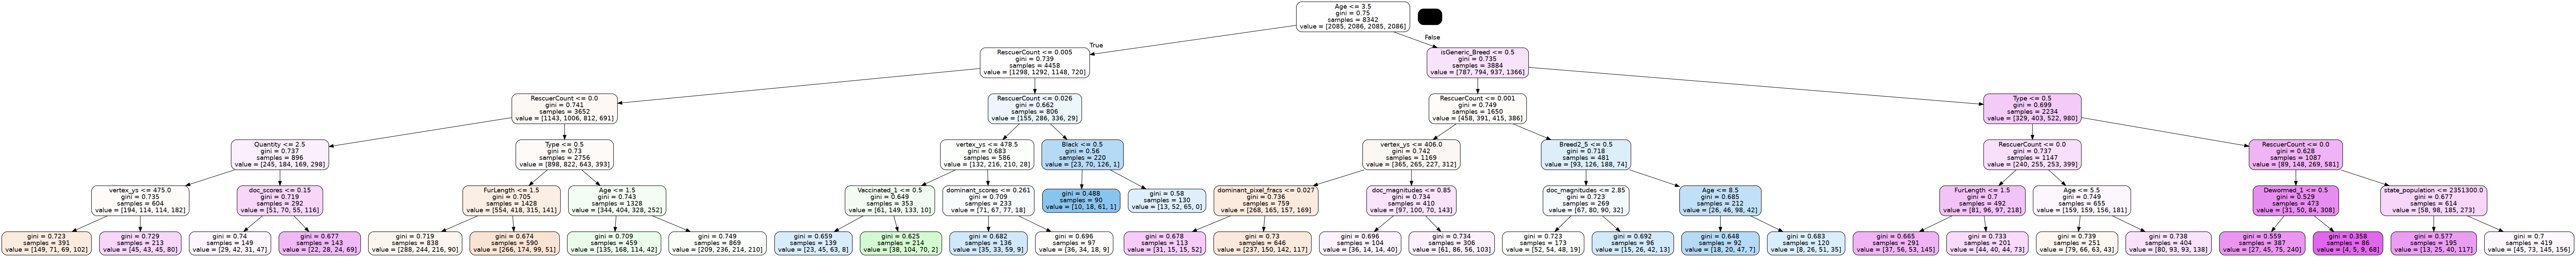

In [36]:
# Display the best decision tree
dot_data = export_graphviz(best_model, out_file=None,
            filled=True, rounded=True, feature_names=features)

graph = pydotplus.graph_from_dot_data(dot_data)

display(Image(graph.create_png()))